In [1]:
# Librerias
import pandas as pd # Para base de datos
import numpy as np # Funciones matematicas
from random import gauss # Numeros aleatorios que siguen distribucion normal
from pandas.plotting import autocorrelation_plot
import warnings 
import itertools
from random import random

In [2]:
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 
# import matplotlib as mpl
import seaborn as sns   

In [3]:
# general settings
class CFG:
    data_folder = '../input/tsdata-1/'
    img_dim1 = 20
    img_dim2 = 10
    
    
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})  


## Patrones
Para identificar patrones en una serie de tiempo, se debe separar en componentes con caracteristicas faciles de comprender:

$$X_t = T_t + S_t + C_t + I_t$$

donde:
* $T_t$: la tendencia que muestra una direccion general de una serie de tiempo a lo largo de un periodo de tiempo (progresion de largo plazo o variacion secular)
* $S_t$: componente estacional con un periodo fijo.
* $C_t$: componente ciclico, el cual no sucede con un periodo fijo (opcional)
* $I_t$: componente irregular (residuos) que consiste en fluctuaciones en la serie de tiempo, observables despues de remover la tendencia y el componente estacional.

Una forma para realizar esta descomposicion es a traves del paquete statsmodel.

In [6]:
help(seasonal_decompose)

Help on function seasonal_decompose in module statsmodels.tsa.seasonal:

seasonal_decompose(x, model='additive', filt=None, period=None, two_sided=True, extrapolate_trend=0)
    Seasonal decomposition using moving averages.
    
    Parameters
    ----------
    x : array_like
        Time series. If 2d, individual series are in columns. x must contain 2
        complete cycles.
    model : {"additive", "multiplicative"}, optional
        Type of seasonal component. Abbreviations are accepted.
    filt : array_like, optional
        The filter coefficients for filtering out the seasonal component.
        The concrete moving average method used in filtering is determined by
        two_sided.
    period : int, optional
        Period of the series. Must be used if x is not a pandas object or if
        the index of x does not have  a frequency. Overrides default
        periodicity of x if x is a pandas object with a timeseries index.
    two_sided : bool, optional
        The moving a

## Ejemplos
### Datos de pasajeros

In [5]:
import os
current_working_directory = os.getcwd()
print("Current Working Directory:", current_working_directory) # Verificar el working directory

Current Working Directory: c:\Users\jpber\OneDrive\Documents\Universidad\QuantConsulting\Time-Series\JP_Bermudez\TS_0\code


<Axes: xlabel='date'>

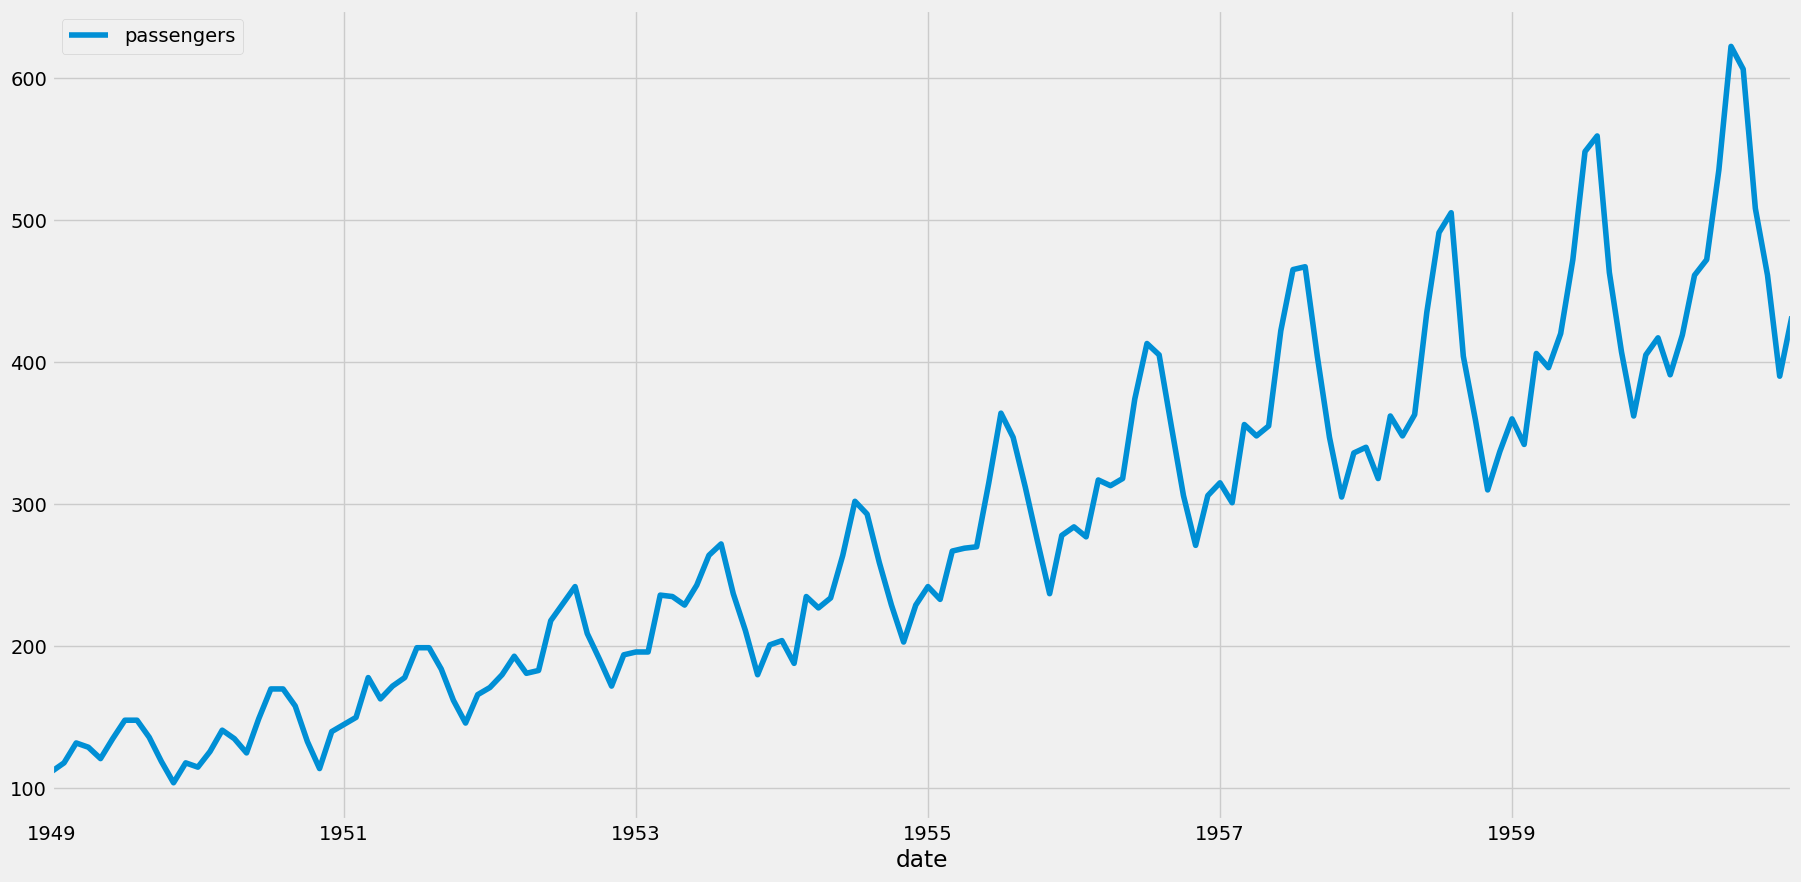

In [7]:
series = pd.read_csv(CFG.data_folder + 'passengers.csv') # Establecer el archivo que se desea, utilizando una carpeta establecida en CFG
series['date'] = pd.to_datetime(series['date']) # Convertir datos en formato de tiempo
series.set_index('date').plot() # Referir indice a la columna de date. Graficar

Comenzaremos con una descomposición aditiva

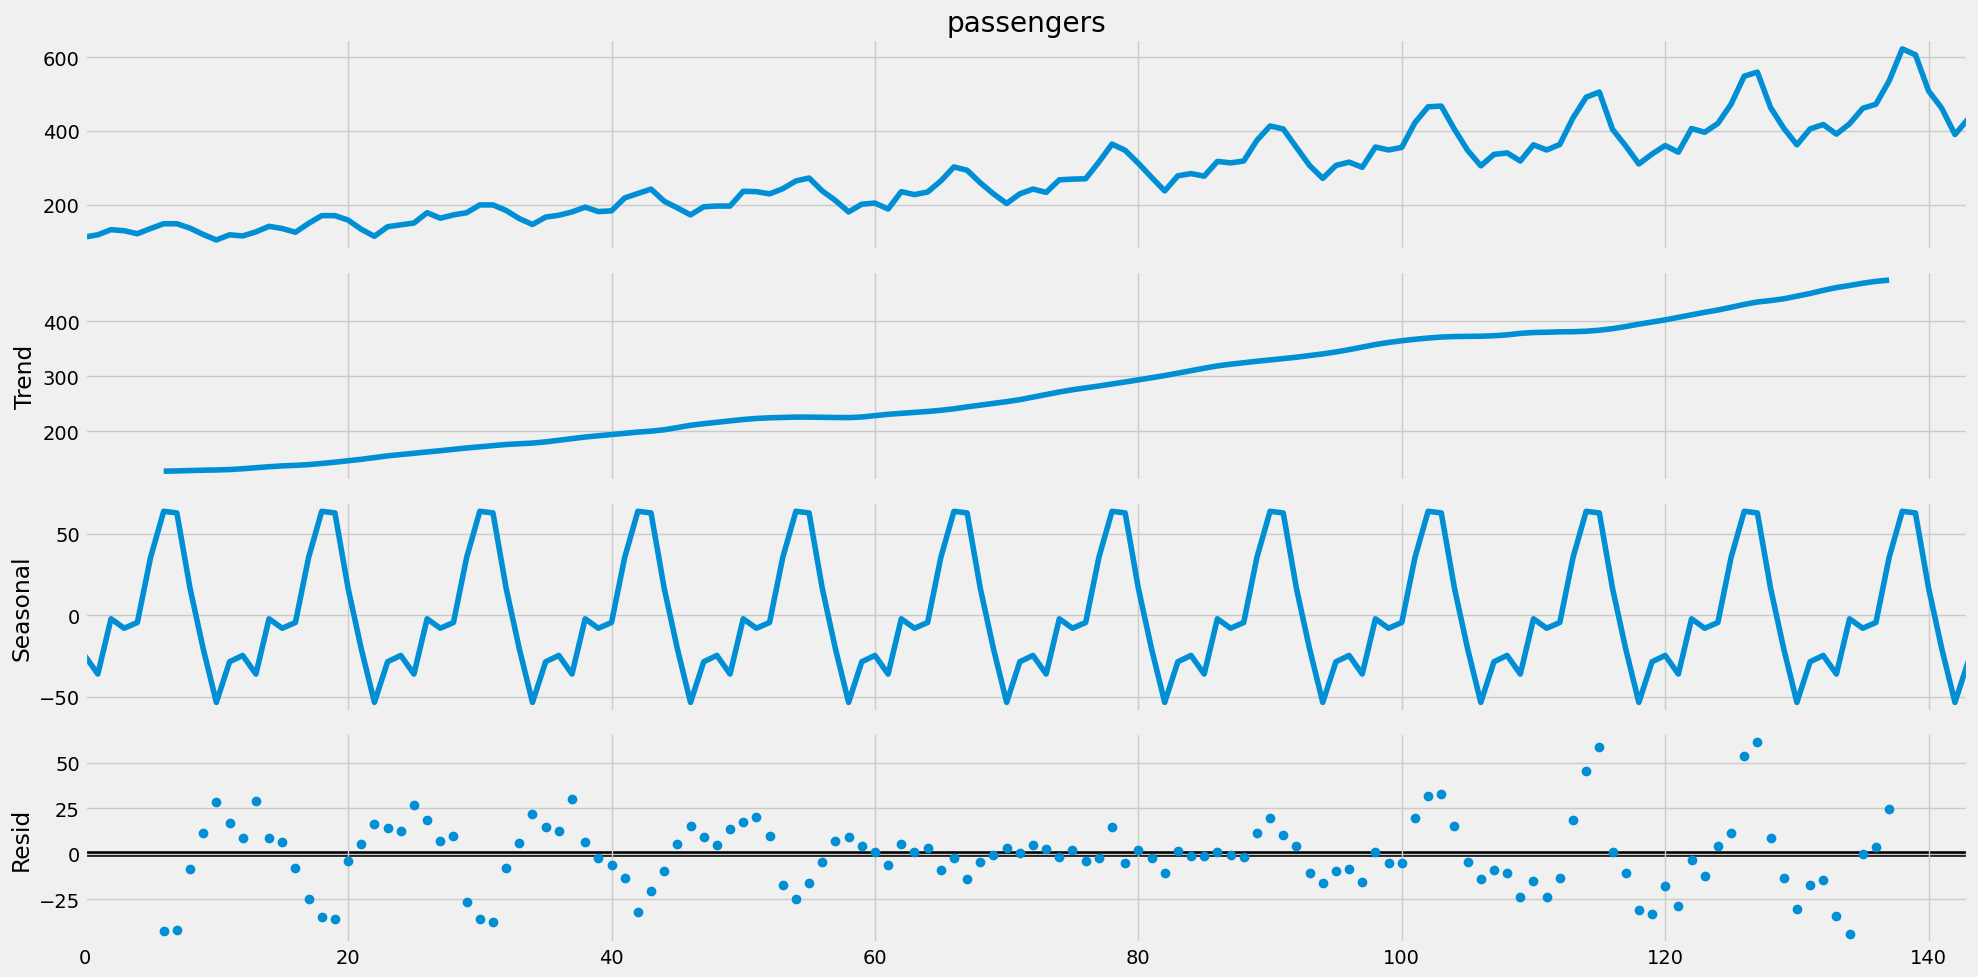

In [8]:
decomposition = sm.tsa.seasonal_decompose(series["passengers"],period =12)  # El objeto a descomponer es la columna de passengers del database series. Periodo 12, se refiere a que es mensual
figure = decomposition.plot()
plt.show()

La tendencia y el componente estacional se comportan según lo esperado, pero el comportamiento de los residuos no es consistente a lo largo del tiempo, las osilaciones son distintas en el medio respecto al inicio o al final. Una primera hipótesis es que la manera adecuada de descomponer no es la aditiva sino multiplicativa.

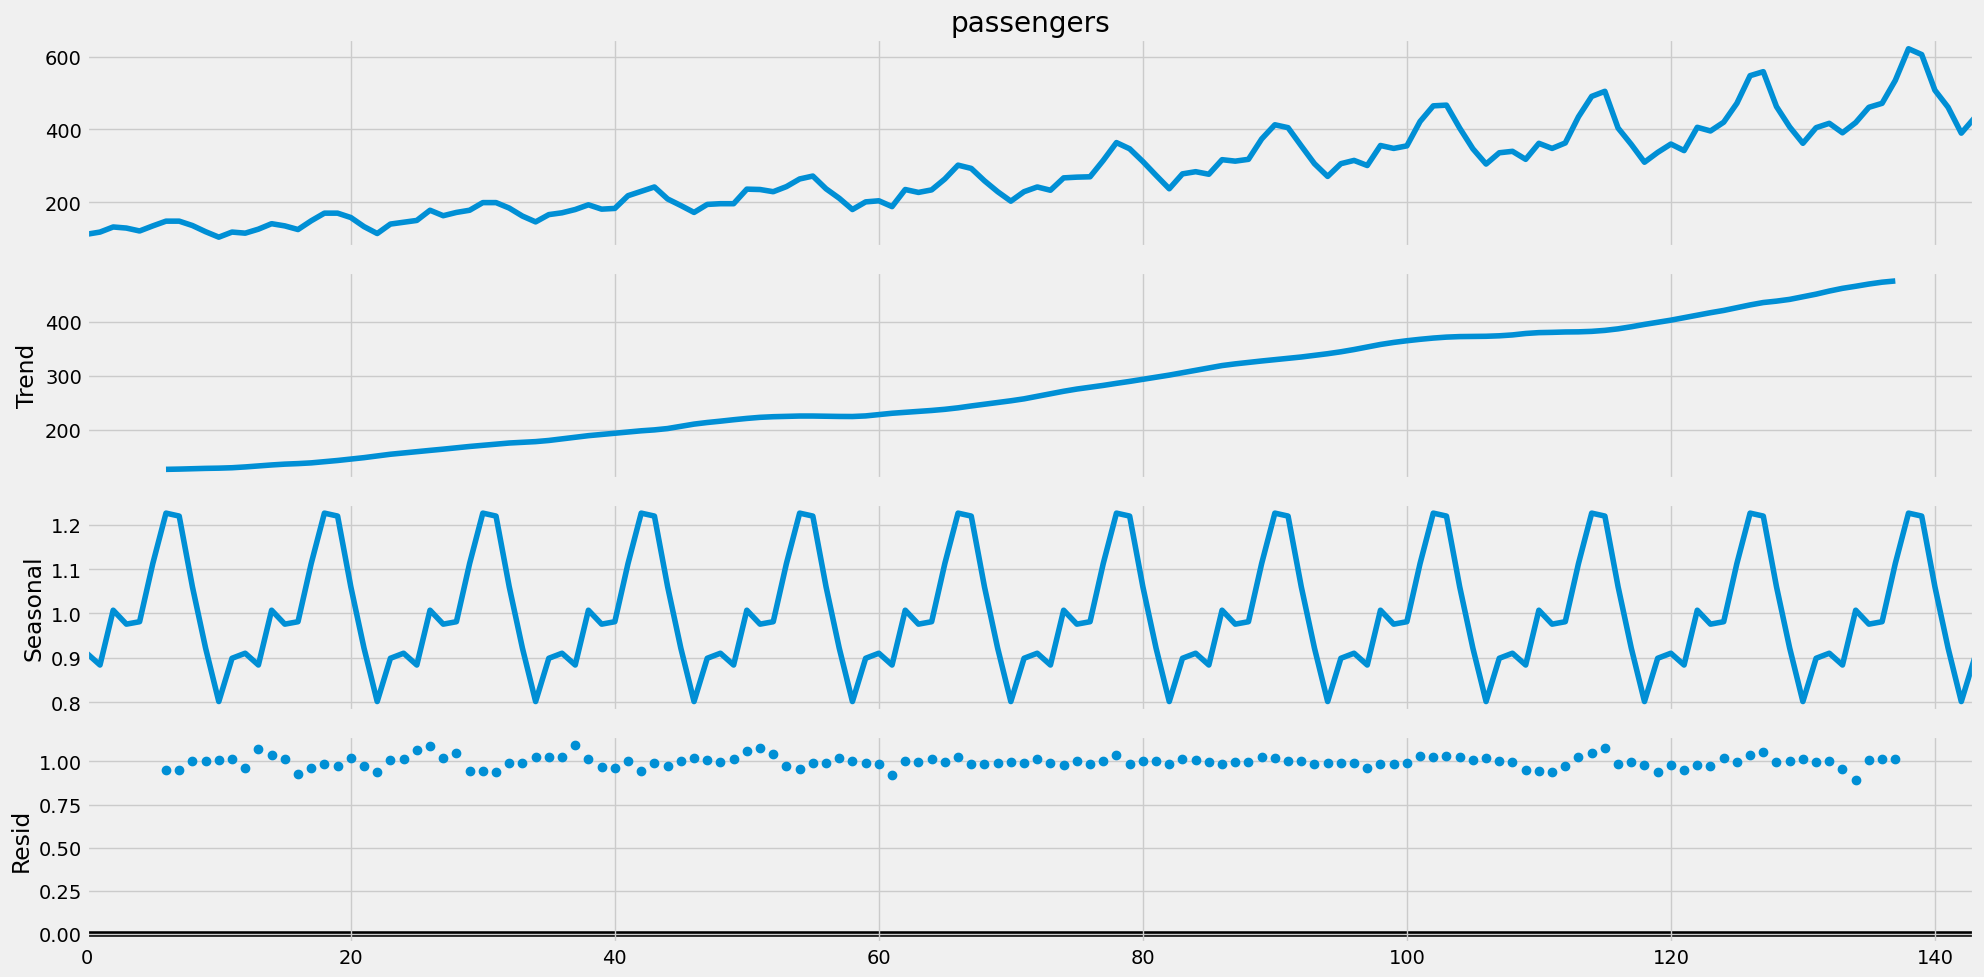

In [9]:
multiplicative_decomposition = sm.tsa.seasonal_decompose(series['passengers'], period=12, model='multiplicative')
figure = multiplicative_decomposition.plot()
plt.show()

No hay muchos cambios en la tendendencia o estacionalidad, pero los residuales se ven mucho mas estables a un nivel constante. 

### Otros ejemplos

<Axes: xlabel='date'>

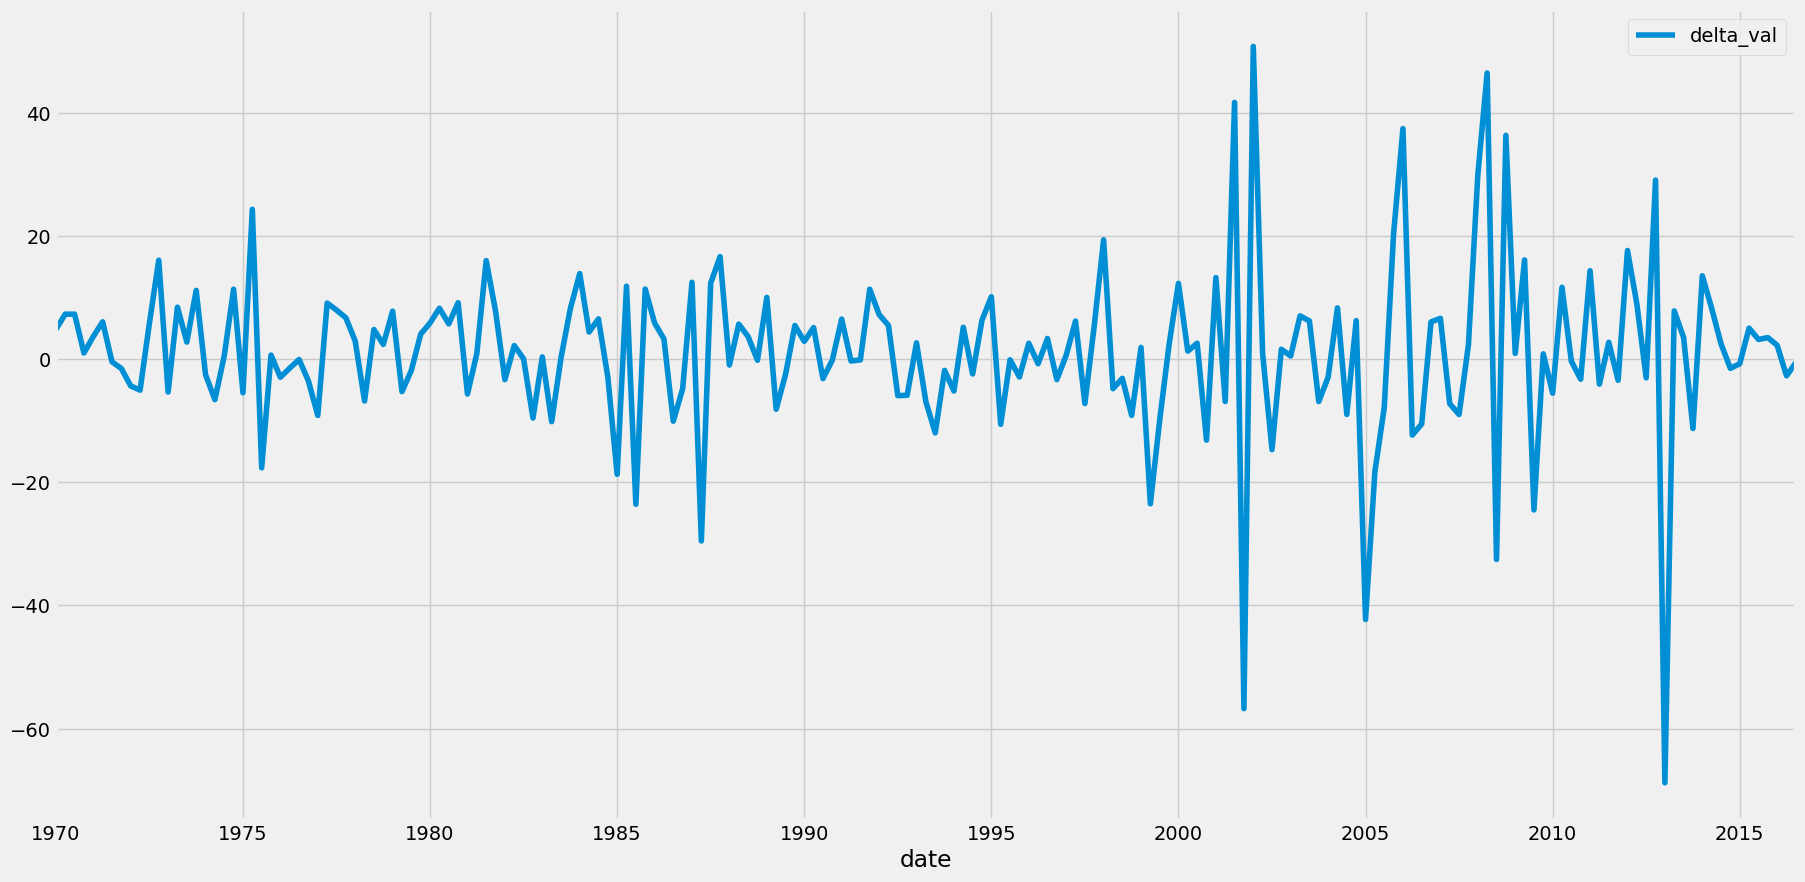

In [10]:
series = pd.read_csv(CFG.data_folder + 'savings_change.csv')
series['date'] = pd.to_datetime(series['date'])
series.set_index('date').plot()

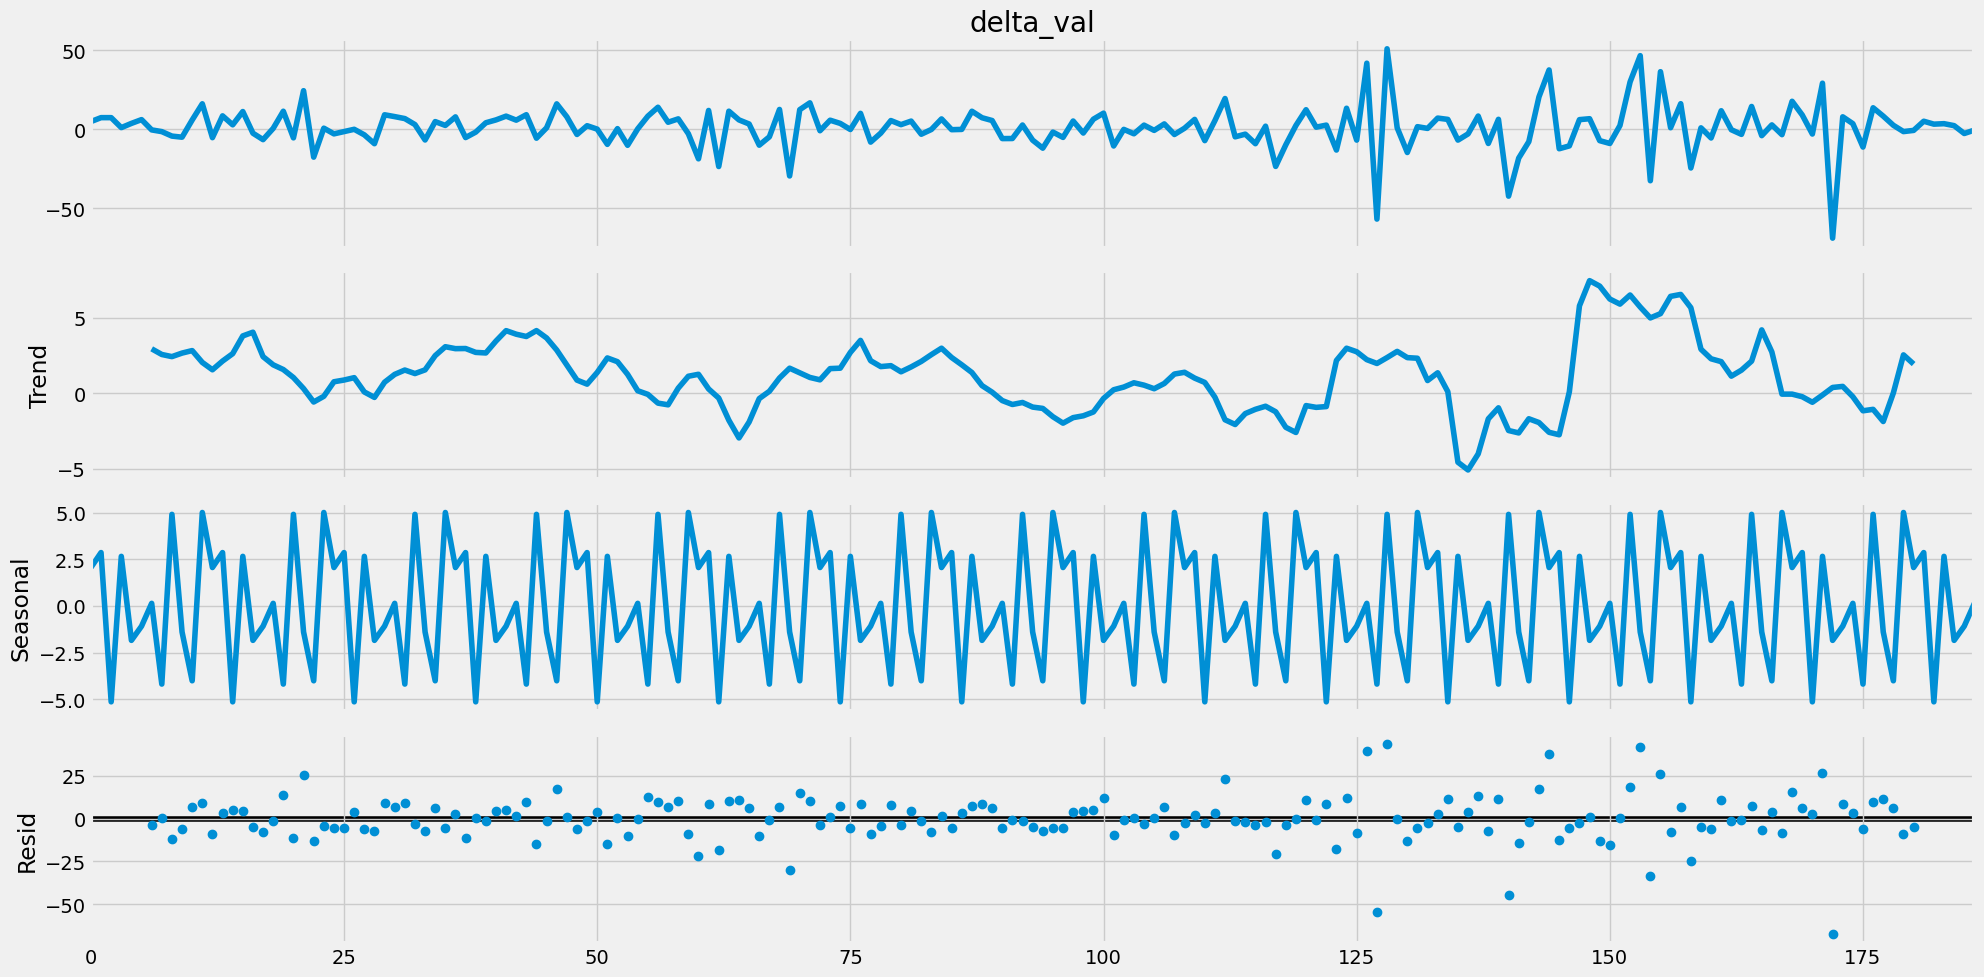

In [11]:
decomposition = sm.tsa.seasonal_decompose(series['delta_val'], period=12)
figure = decomposition.plot()
plt.show()

## Dependencia
Una manera de calcular la dependencia entre los valores de una serie de tiempo es a traves de las funciones de autocorrelacion y autocorrelacion parcial.
La forma mas intuitiva de entender la ACF es que en el rezago _k_ mide una dependencia linear entre $X_t$ y $X_{t+k}$ mientras que la PACF captura la dependencia entre estos valores corrigiendo por todos los efectos intermedios.

## Estacionariedad
Para mayor formalidad, una serie de tiempo estacionaria es aquella cuya distribucion de probabilidad conjunta no condicional no cambia al haber cambios en el tiempo. Esto implica que parametros como la media y la varianza no cambian a lo largo del tiempo.

Es mucho mas facil modelar un comportamiento dinamico si las propiedades estadisticas no cambian con el paso del tiempo: las oscilaciones suceden en el mismo nivel, la amplitud no cambia mucho, etc. Ademas, los algoritmos generan mejores predicciones si las aplicamos a procesos estacionarios.

Primero se grafica un ejemplo claro de proceso estacionario: ruido blanco gaussiano.

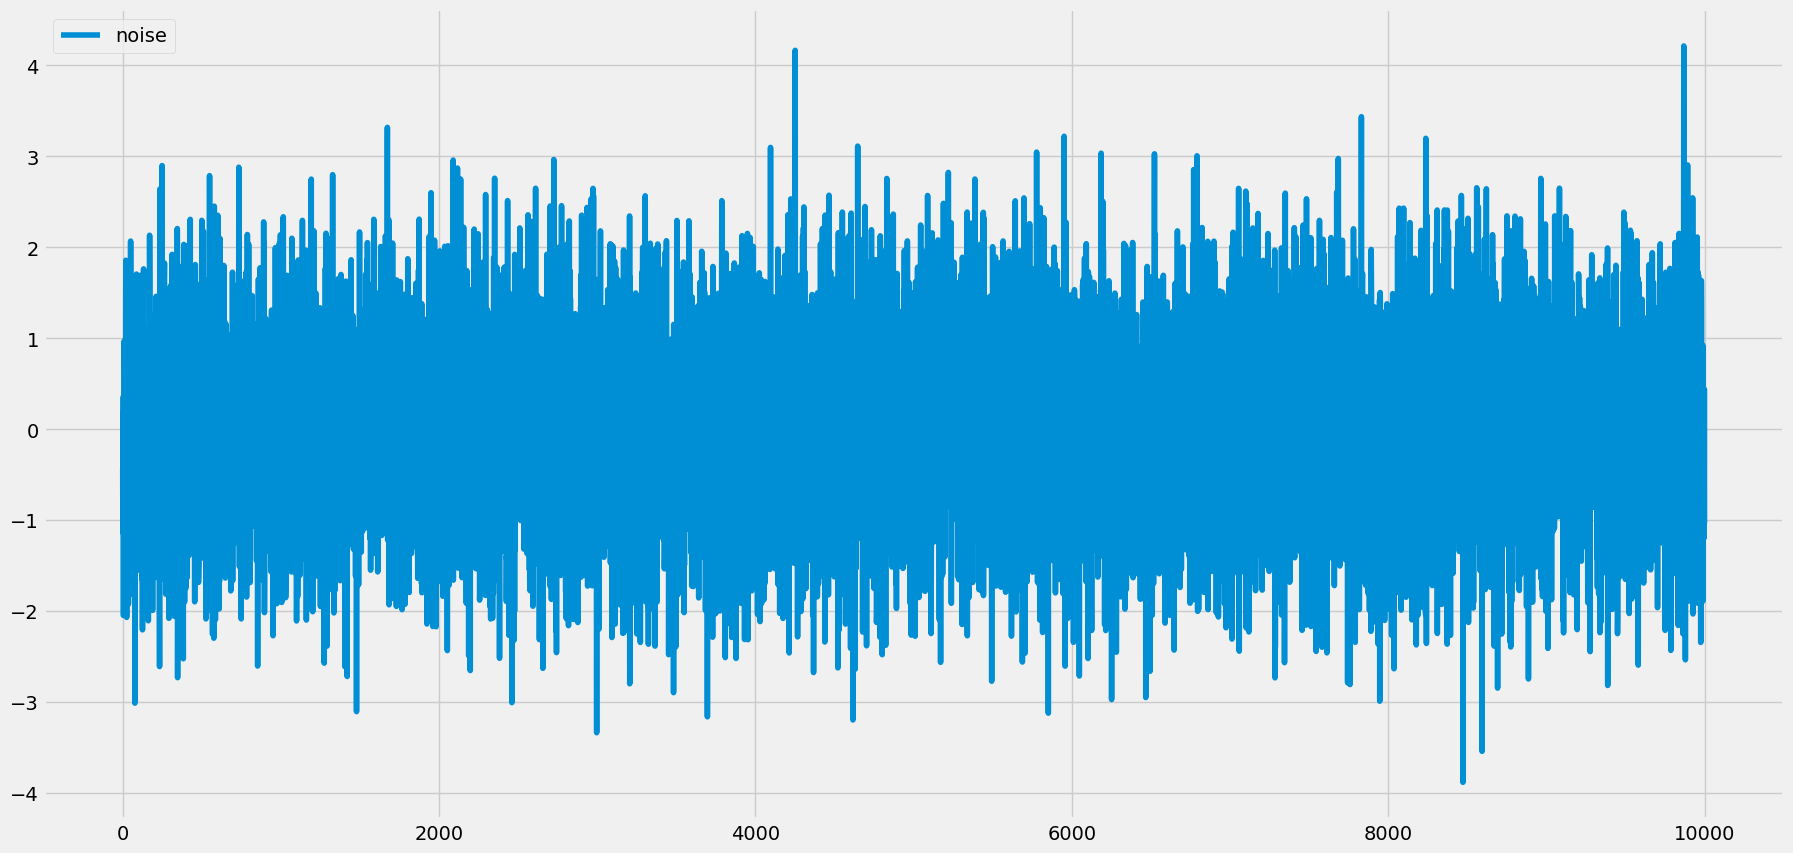

In [12]:
xseries = pd.DataFrame(data = np.random.normal(0, 1, 10000), columns = ['noise'] ) # 10000 valores que siguen distribucion normal con media 0 y varianza 1
xseries.plot()
print()

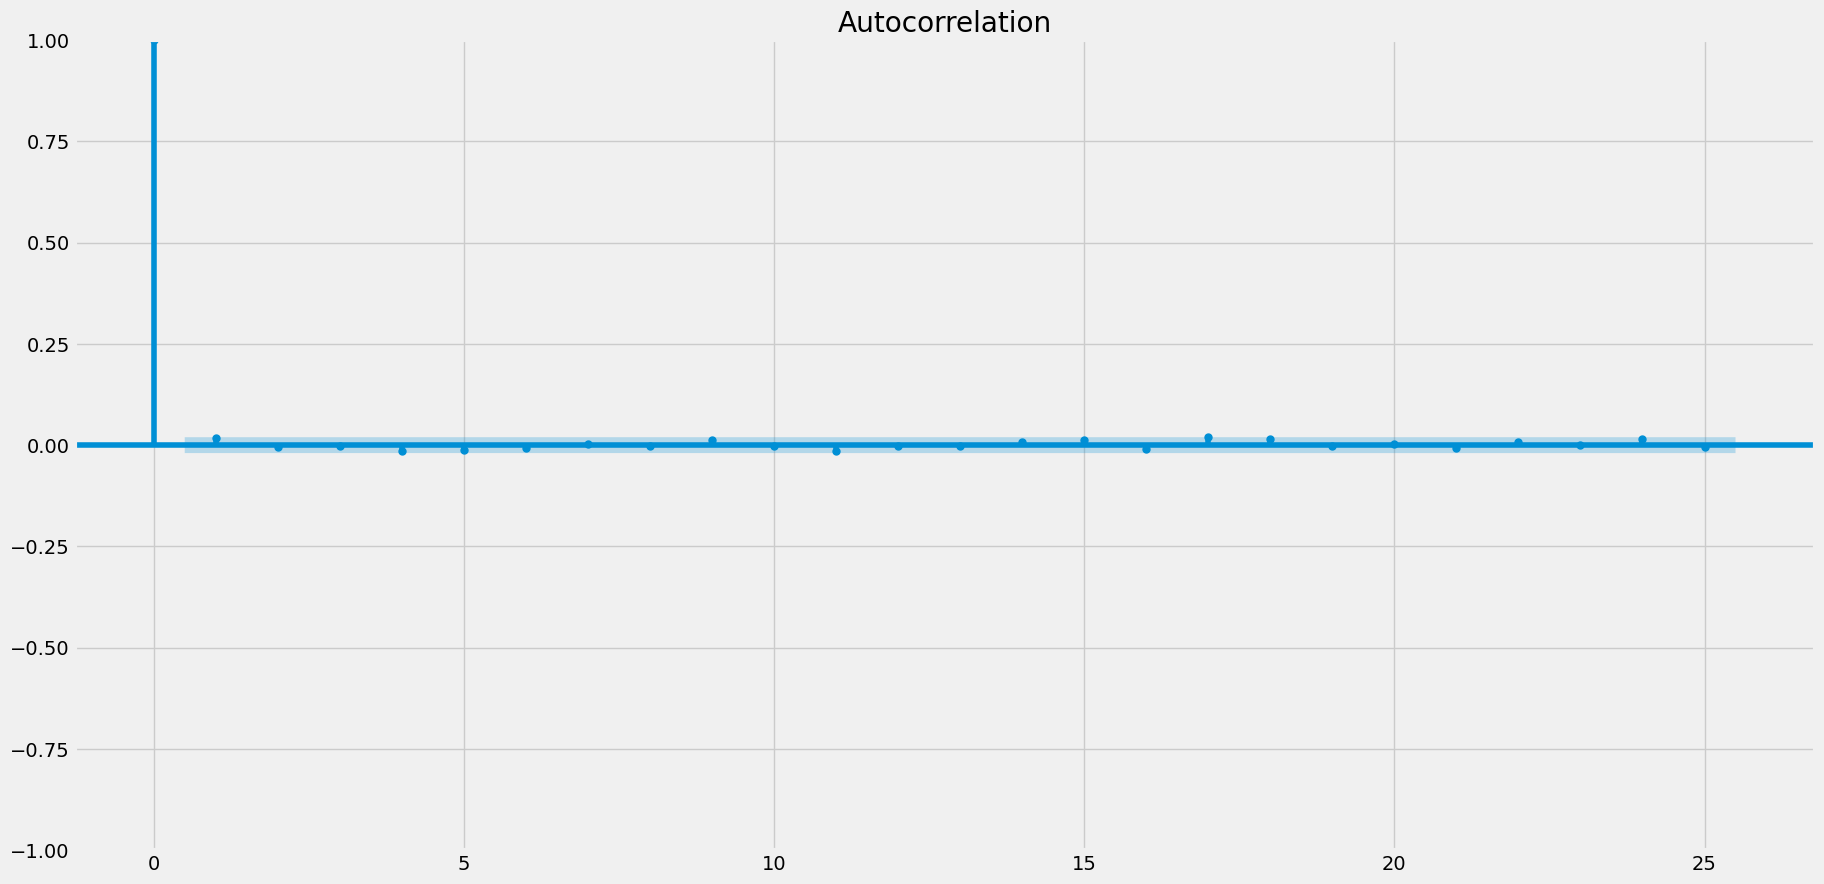

In [13]:
# Graficar la funcion de autocorrelacion usando los primeros 25 rezagos
plot_acf(xseries['noise'], lags = 25) # funcion plot_acf()
print()

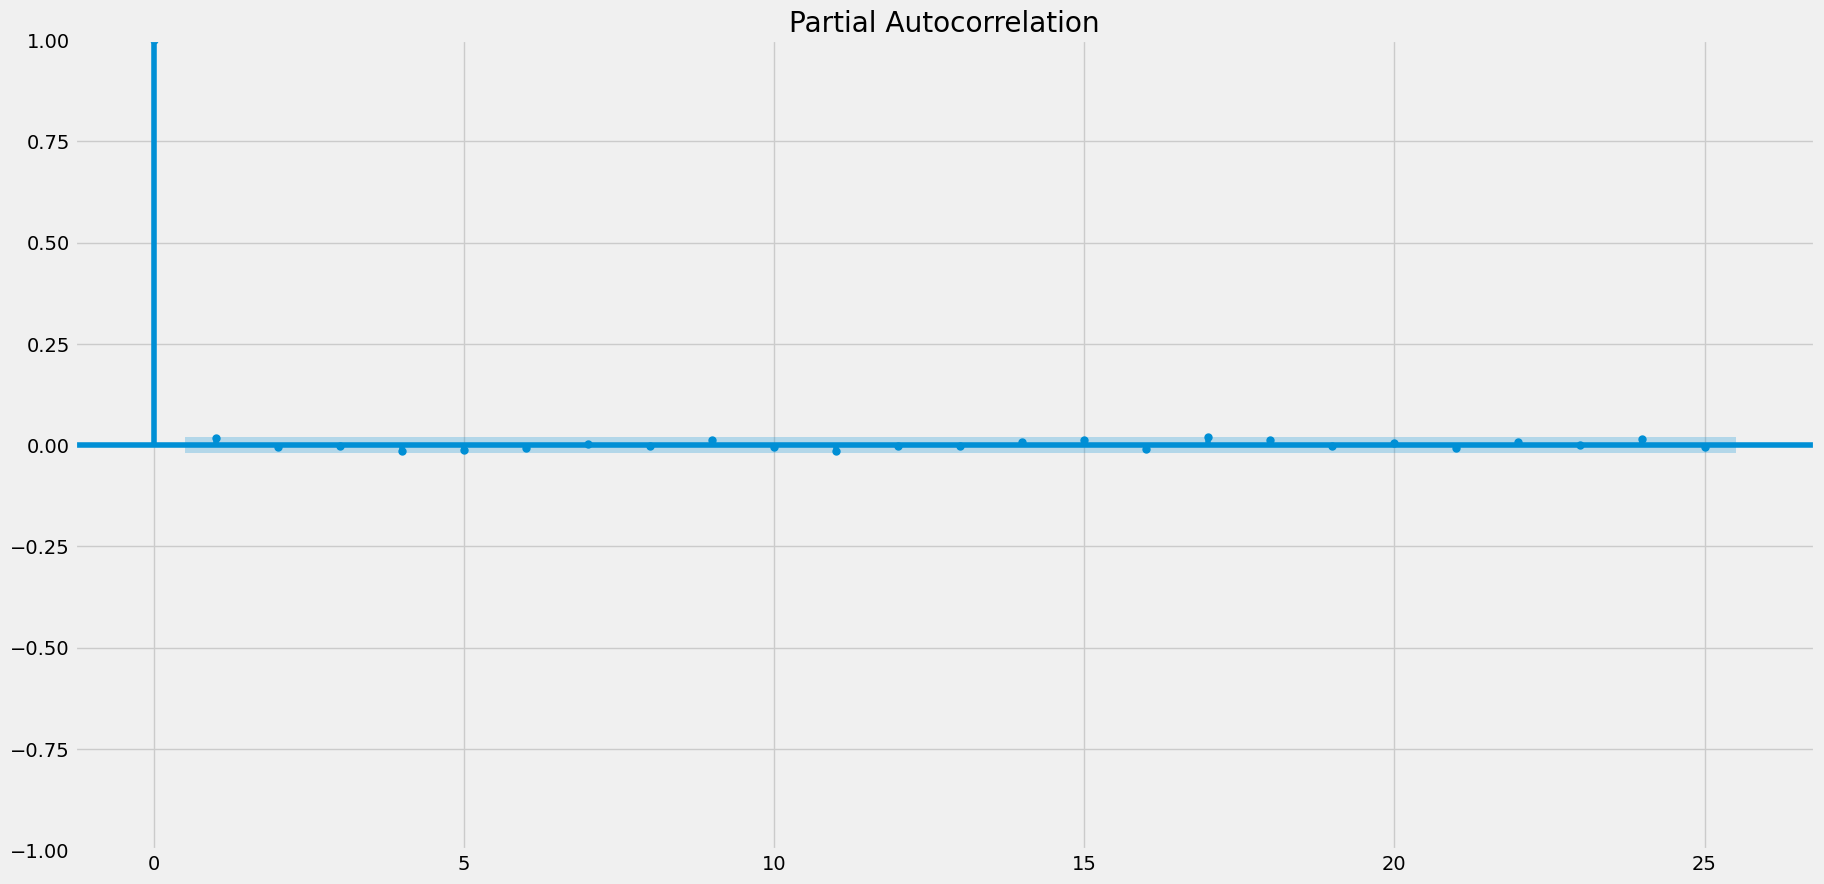

In [14]:
plot_pacf(xseries['noise'], lags = 25)
print()

<Axes: xlabel='date'>

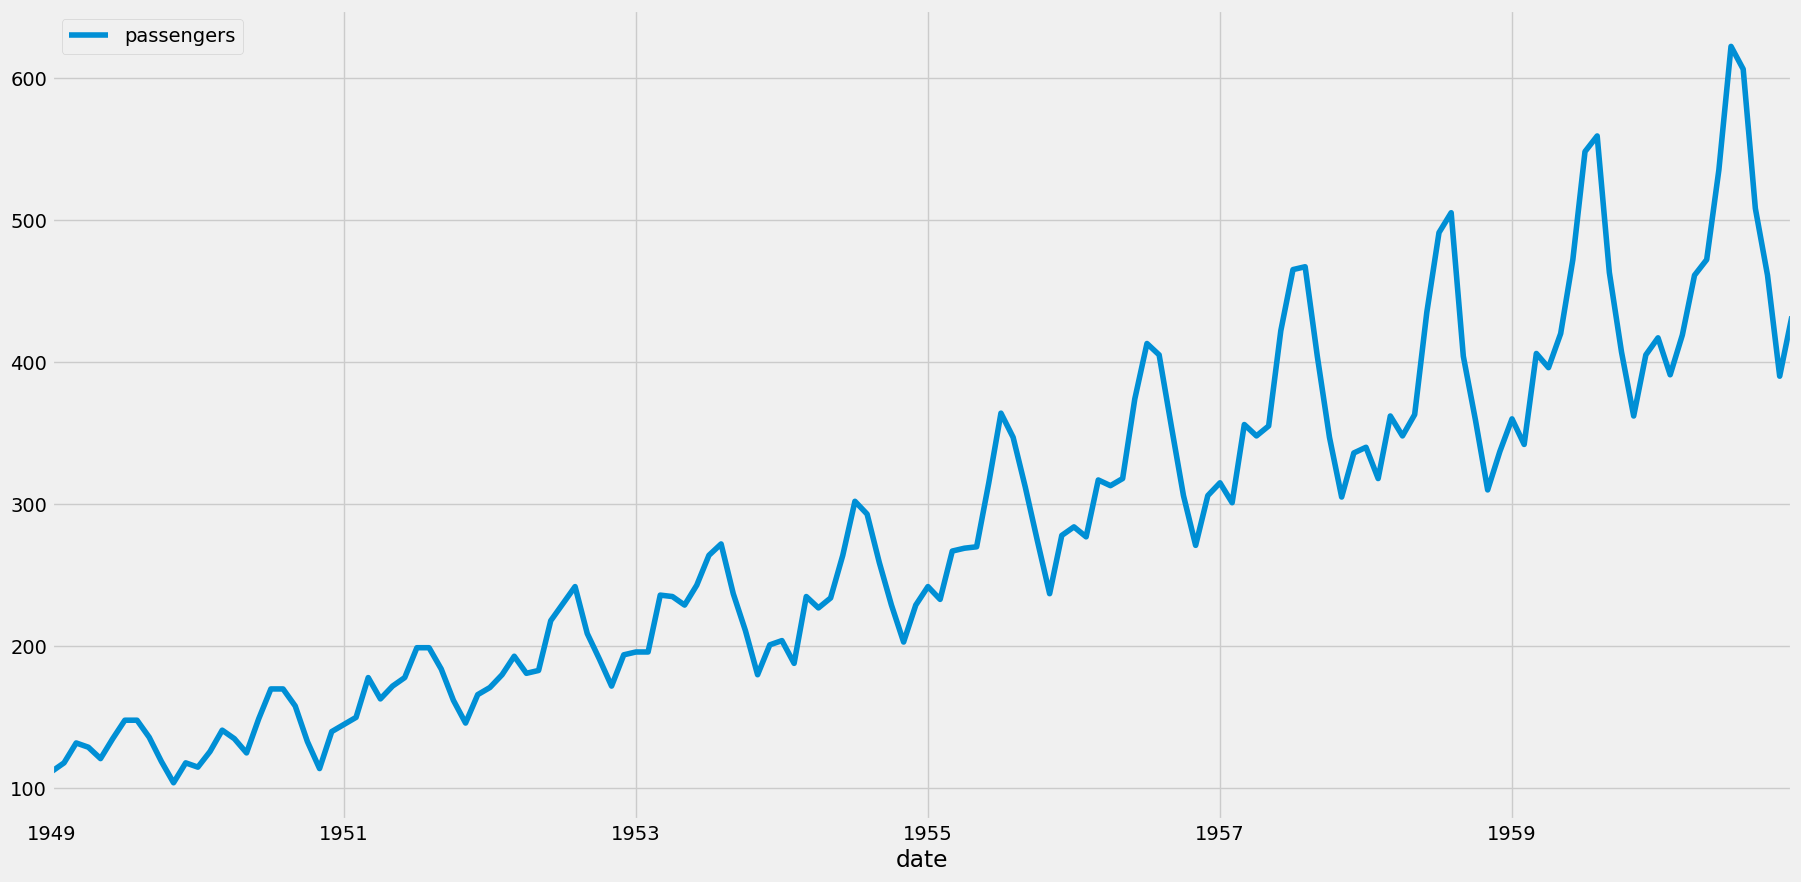

In [15]:
# Otro ejemplo de serie no estacionaria
series = pd.read_csv(CFG.data_folder + 'passengers.csv')
series['date'] = pd.to_datetime(series['date'])
series.set_index('date').plot()

## Estacionariedad debil
Se dijo anteriormente que la estacionariedad depende de la distribucion de probabilidad de la serie de tiempo. Pero, dado que no siempre se sabe esta funcion, se pueden relajar los supuestos y establecer la estacionariedad debil, que esta definida como:
* media constante
* covarianza solamente depende de la distancia en el tiempo entre variables
* varianza finita y constante

### Tests para estacionariedad

* ADF (augmented Dickey Fuller)
* KPSS
* PP (Philips-Perron)

ADF es un test de raiz unitaria. Determina que tan fuerte esta definida una serie de tiempo por una tendencia:
* $H_0$: la serie de tiempo puede ser representada por una raiz unitaria, es decir no es estacionaria
* $H_1$: la serie de tiempo es estacionaria

La interpretacion del $p_{value}$:
* Mayor que $\alpha$: se acepta la hipotesis nula, hay presencia de raiz unitaria y la serie no es estacionaria
* Menor que $\alpha$: se rechaza la hipotesis nula, la serie es estacionaria.

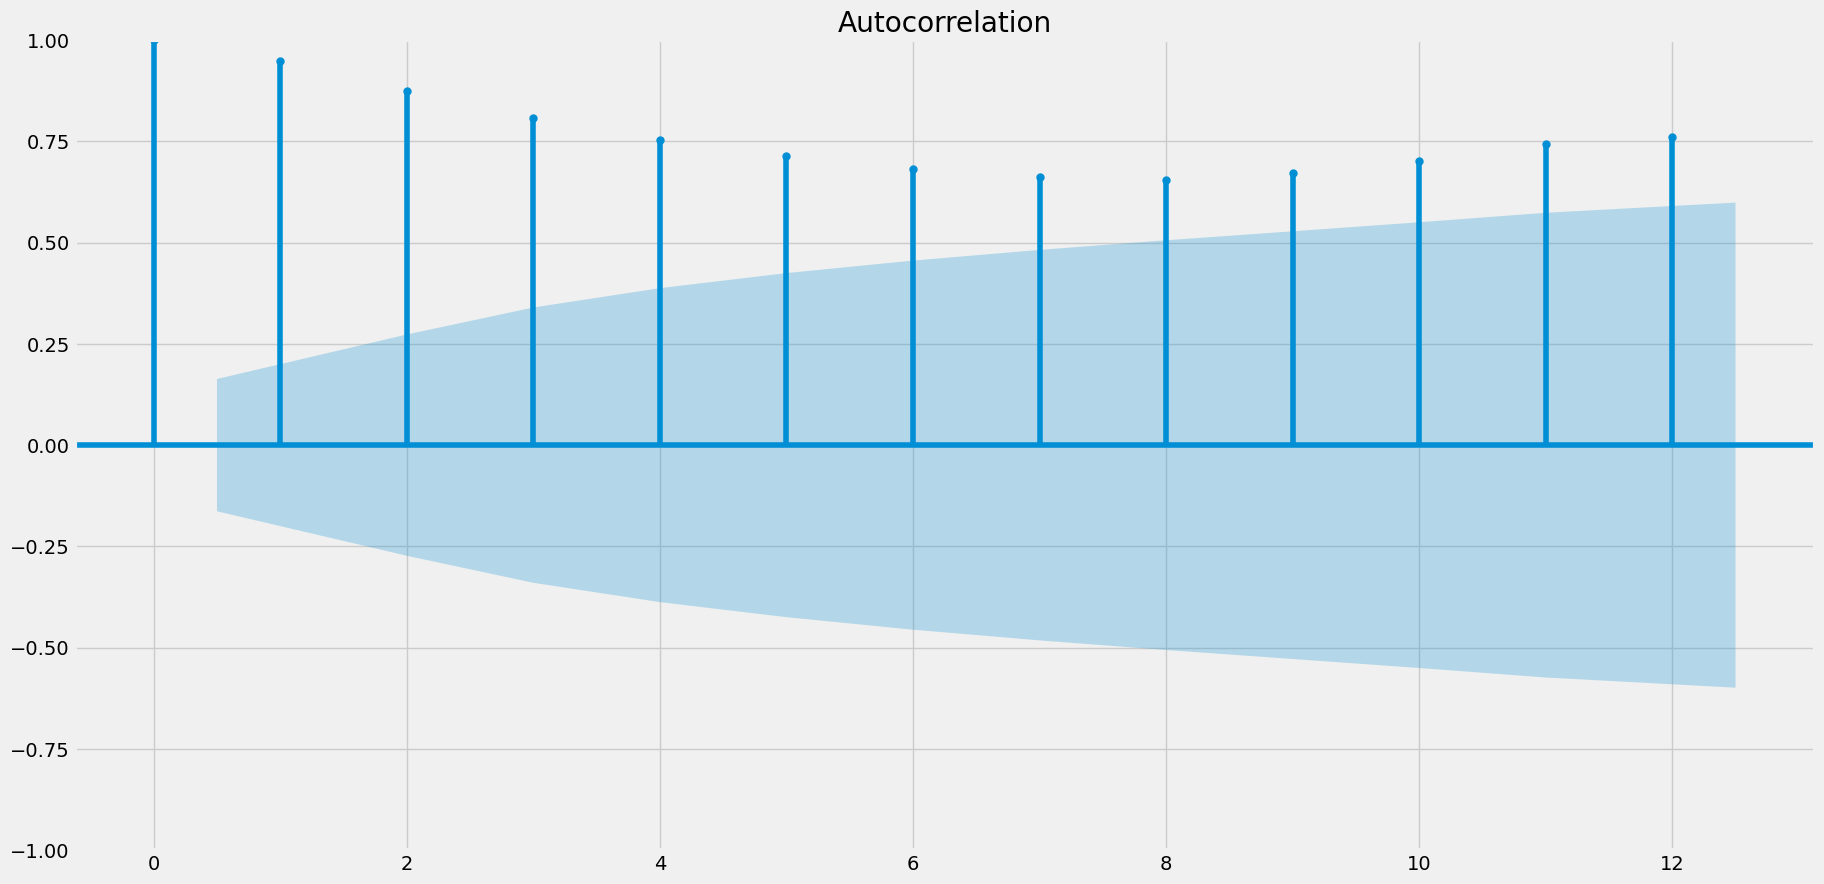

In [18]:
# ACF
plot_acf(series['passengers'], lags = 12)
plt.show()

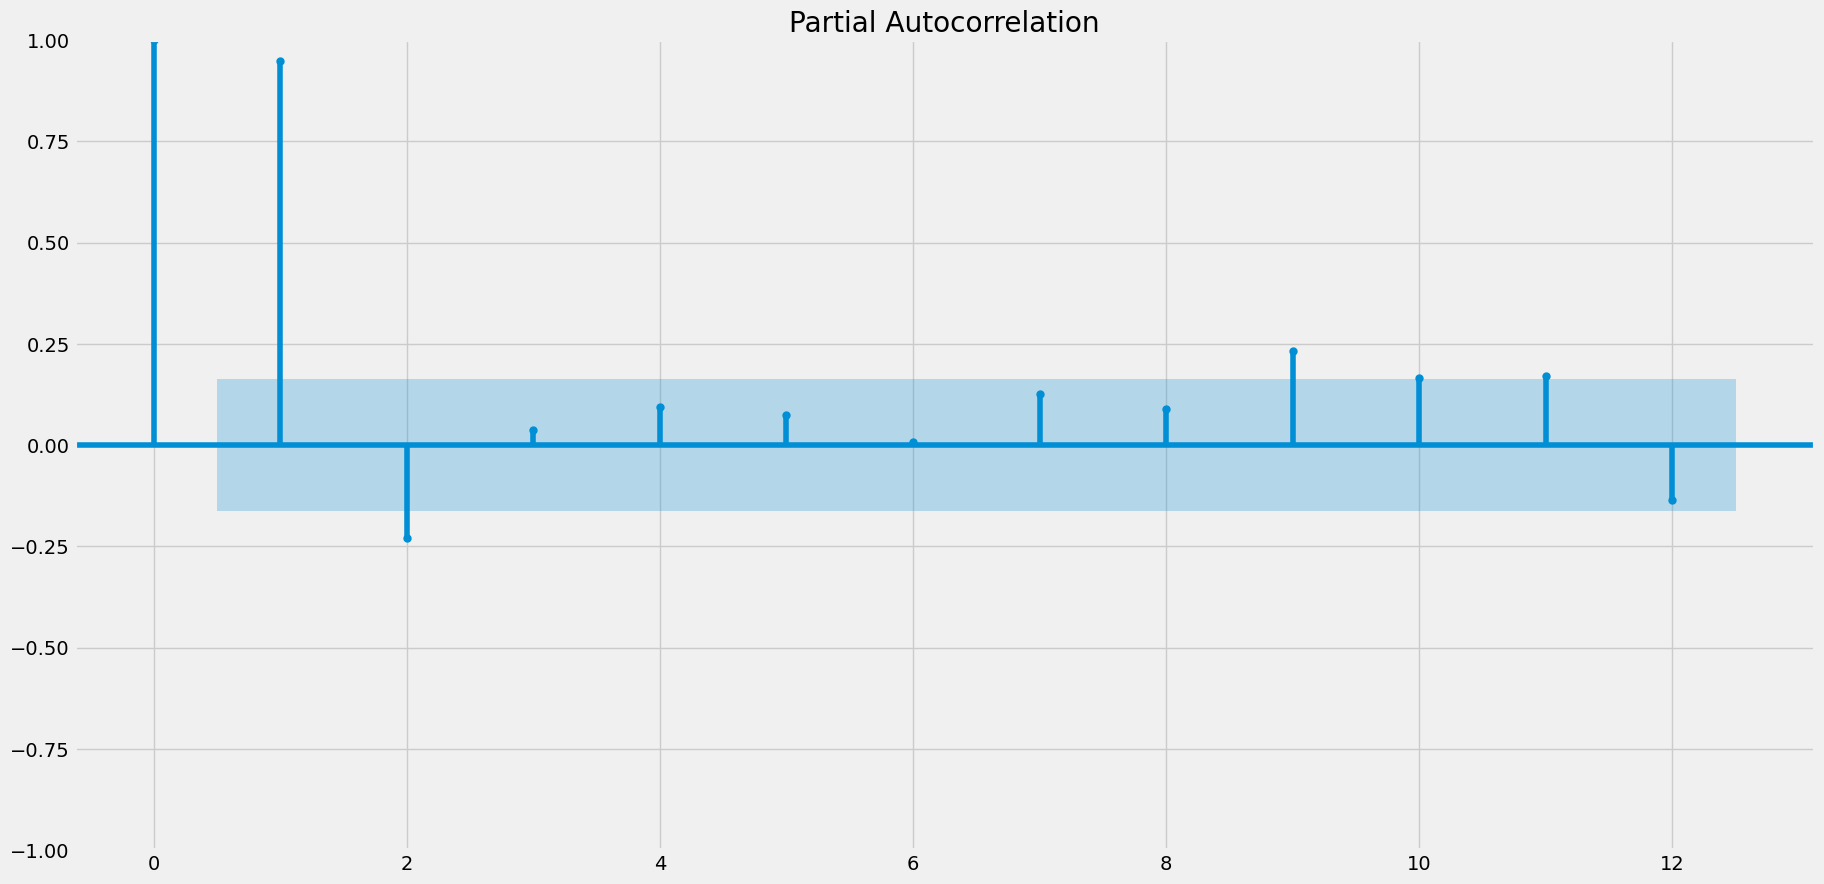

In [19]:
# PACF
plot_pacf(series['passengers'], lags = 12)
plt.show()

Se puede observar que mas del primer rezago es significativo por lo cual es no estacionario. Se puede descomponer la serie para ver que componentes son responsables por el comportamiento no estacionario.

In [20]:
decomposition = seasonal_decompose(series['passengers'], period = 12)

In [21]:
# Prueba de Dickey Fuller
X = series['passengers']
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic: 0.815369
p-value: 0.991880
Critical Values:
	1%: -3.482
	5%: -2.884
	10%: -2.579


In [22]:
# skip the start of the series: adfuller does not handle missing values which appear for values within the first full period
result = adfuller(decomposition.trend[10:-10])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 1.025948
p-value: 0.994532


In [23]:
result = adfuller(decomposition.seasonal[10:-10])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -7952463448638289.000000
p-value: 0.000000


In [24]:
result = adfuller(decomposition.resid[10:-10])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -5.029170
p-value: 0.000019


Como se puede observar, la hipotesis de no estacionariedad no se rechaza para la tendencia, pero si para el componente estacional.

### Transformaciones para volver una serie estacionaria
* Logaritmo
* Diferenciar

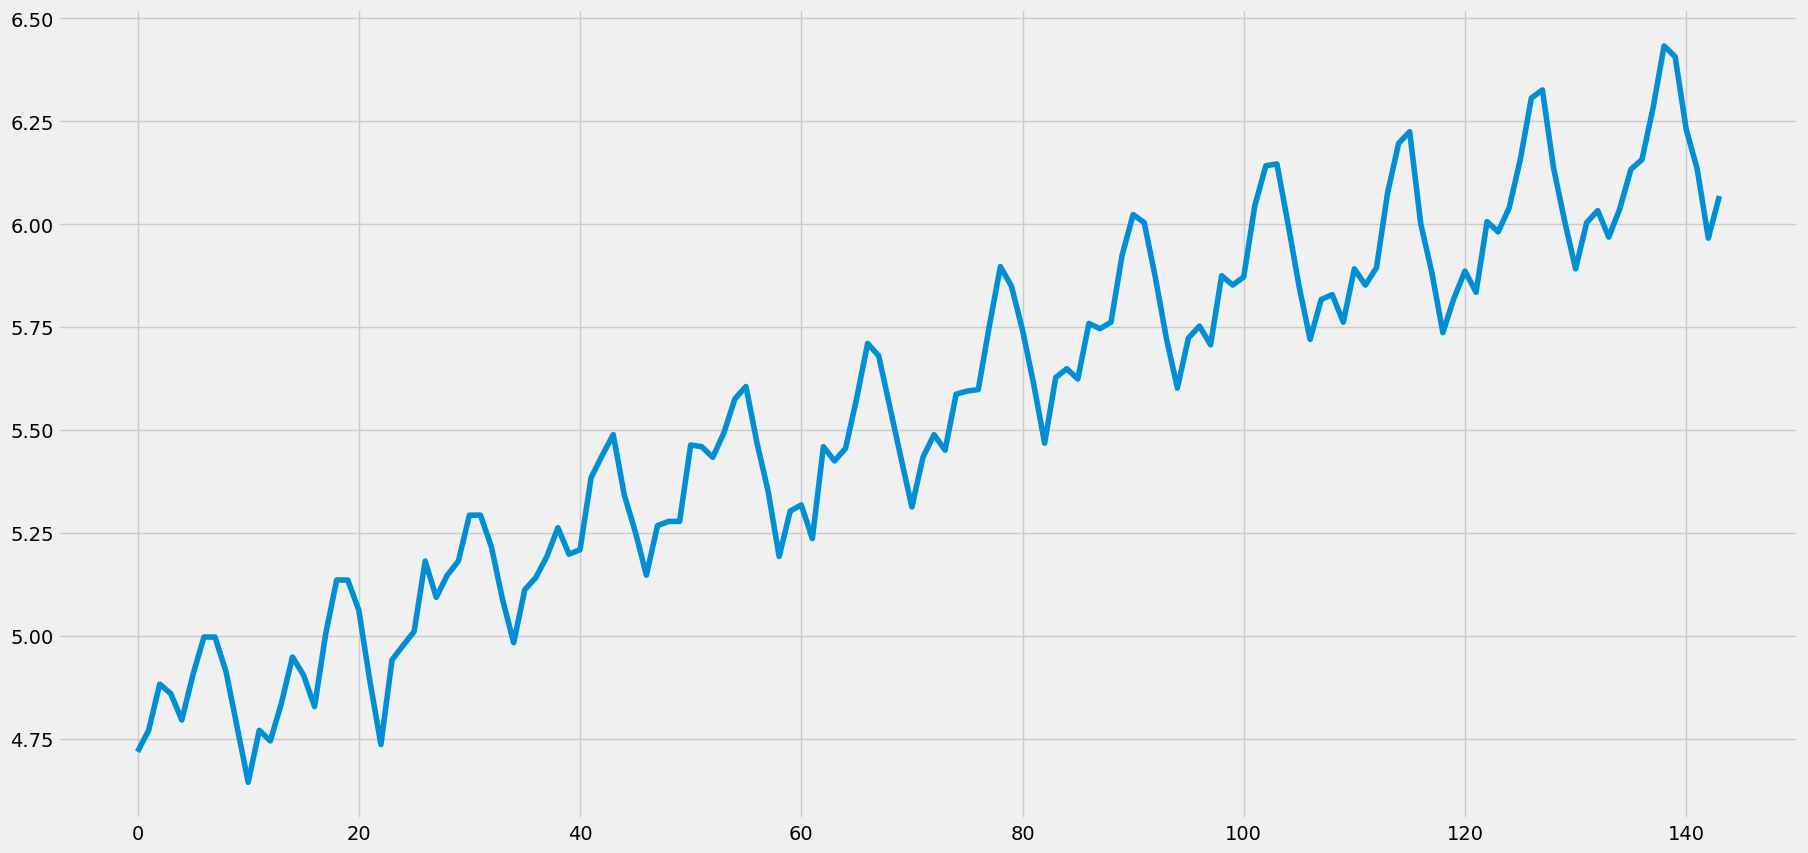

In [25]:
series['passengers2'] = np.log(series['passengers'])
series.passengers2.plot()
plt.show()

In [26]:
result = adfuller(series.passengers2)
print('p-value: %f' % result[1])

p-value: 0.422367


El pvalue se reduce, es decir, sigue siendo no estacionaria pero al reducir la amplitud (varianza) de la serie de tiempo, se puede decir que se está yendo en buen camino. Sigue diferenciar la serie

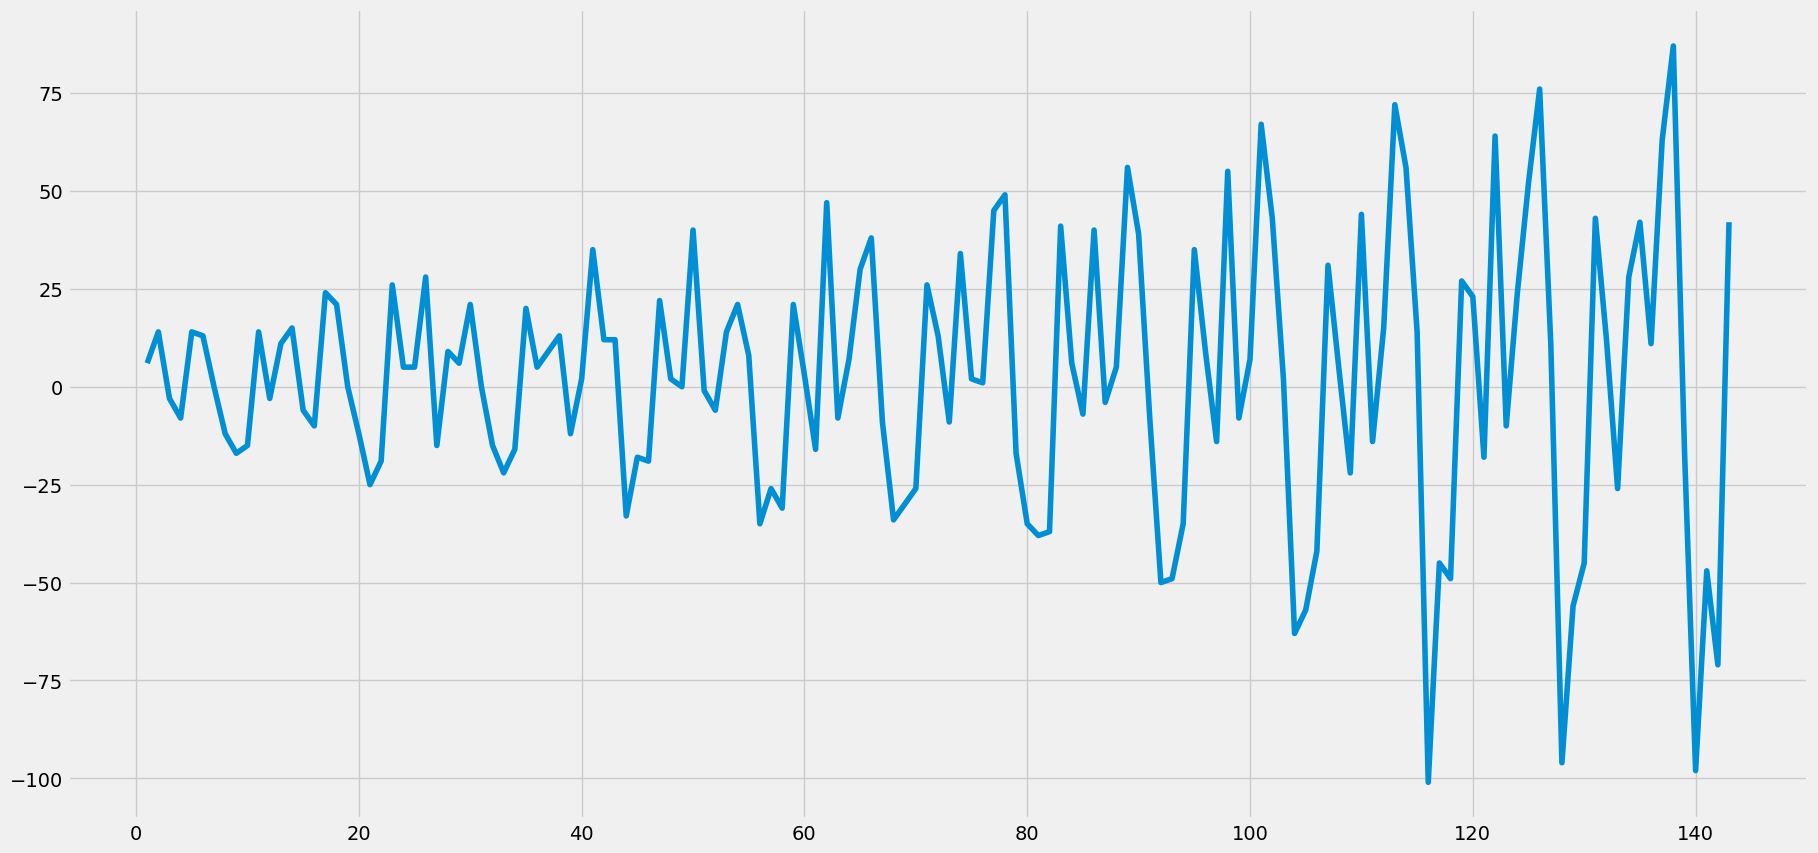

In [27]:
series['passengers3'] = series['passengers'].diff()
series.passengers3.plot()
plt.show()

Solo al diferenciar, se elimina la tendencia pero las oscilaciones siguen dependiendo del tiempo, por que no se aplico la transformacion logaritmica.

In [28]:
result = adfuller(series.passengers3[10:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -2.830154
p-value: 0.054094


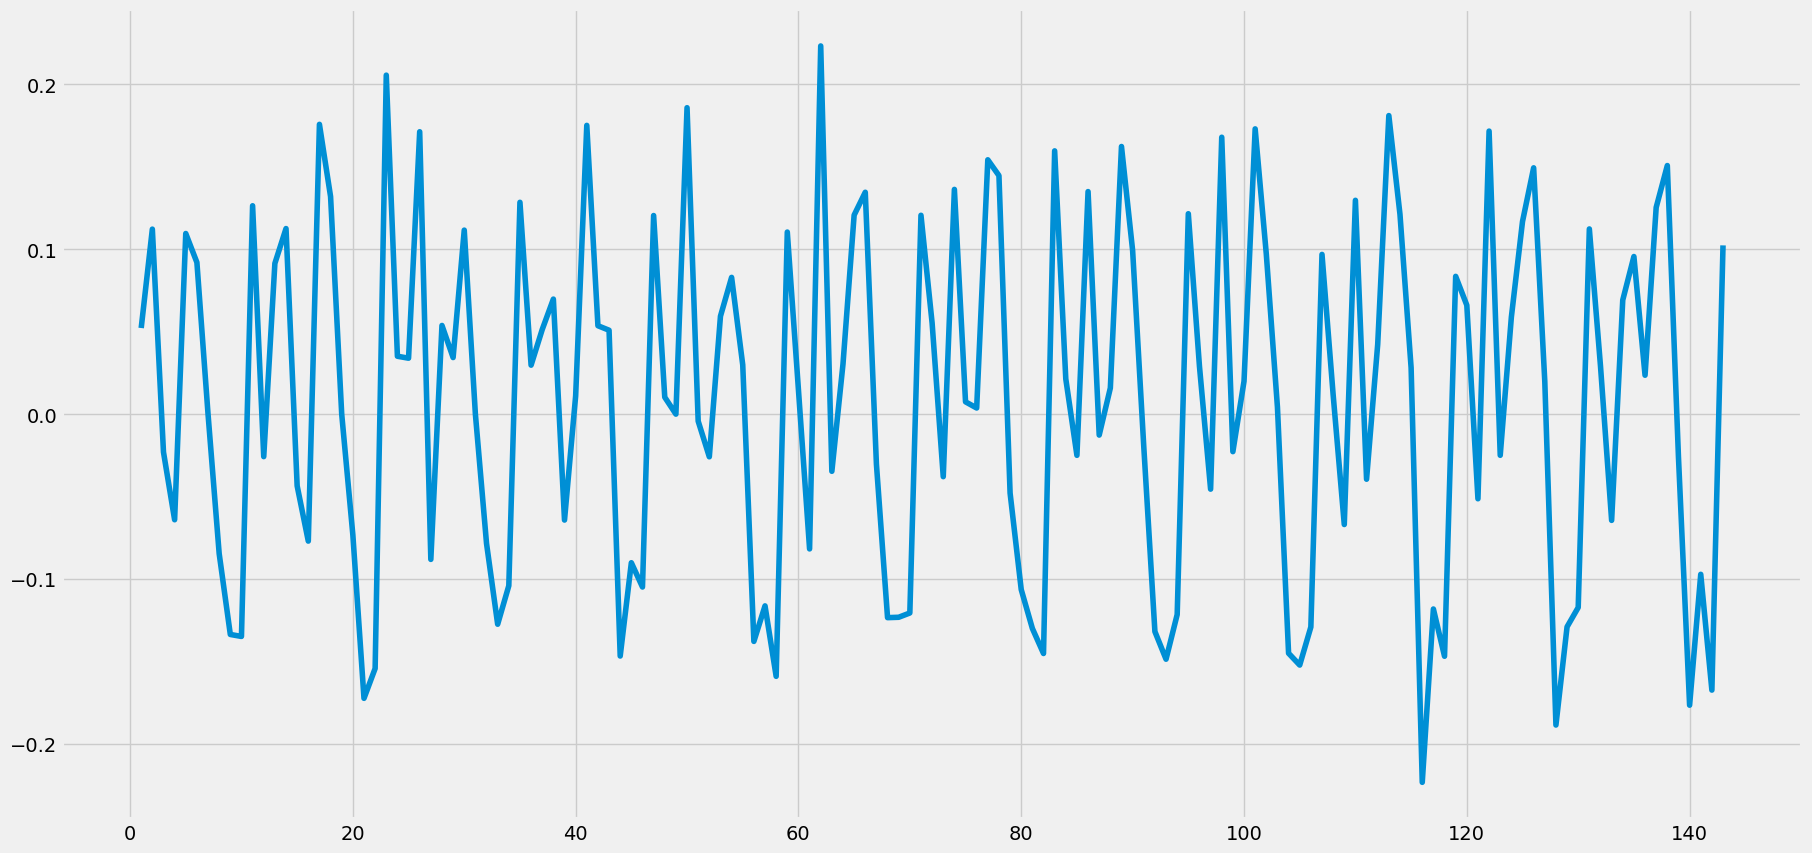

In [29]:
series['passengers4'] = series['passengers'].apply(np.log).diff()
series.passengers4.plot()
plt.show()

In [30]:
result = adfuller(series.passengers4[10:])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -3.086110
p-value: 0.027598


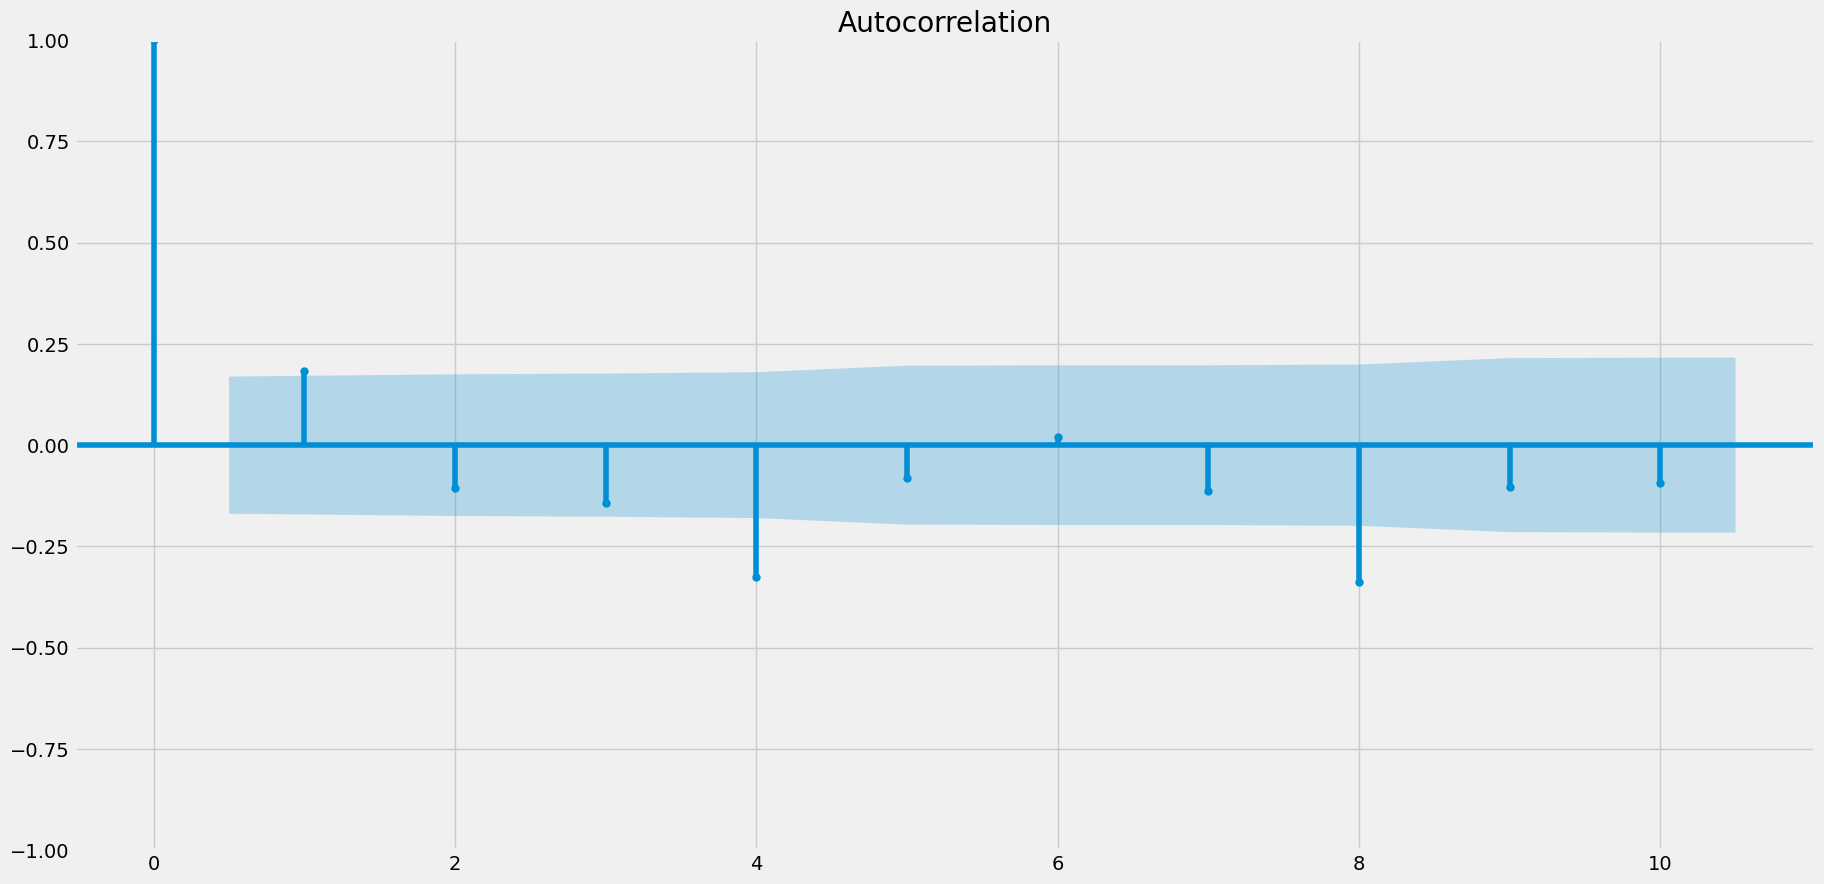

In [31]:
# Veamos que es estacionaria al revisar la ACF y PACF
plot_acf(series['passengers4'][10:], lags = 10)
plt.show()

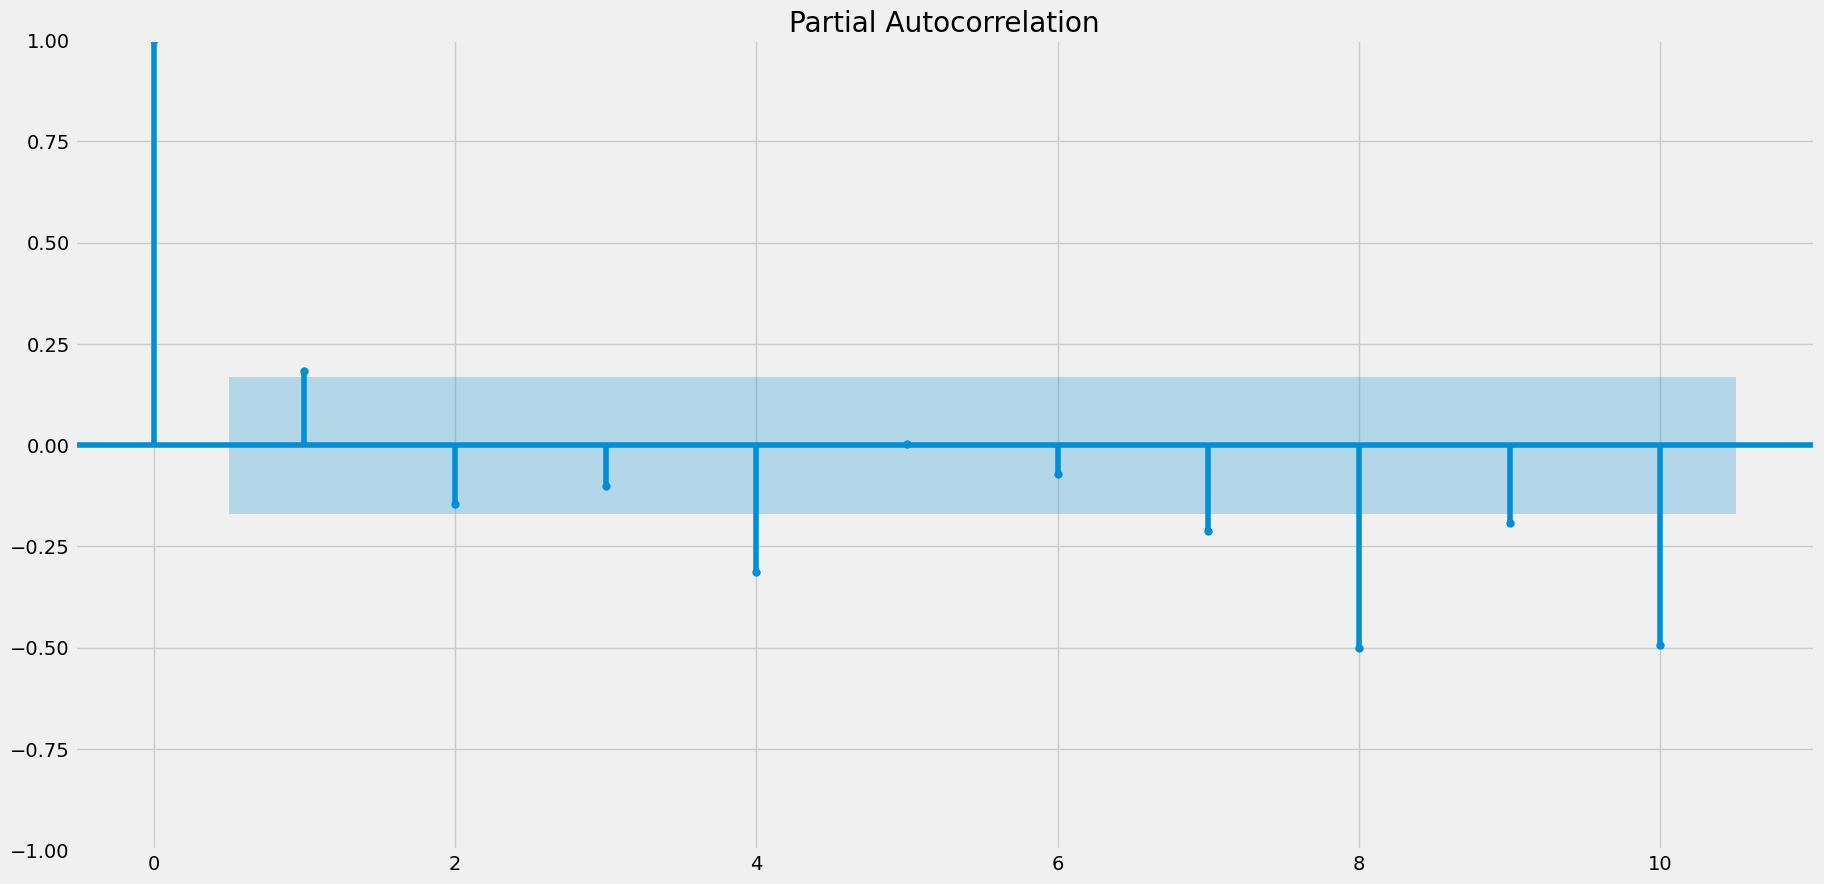

In [32]:
plot_pacf(series['passengers4'][10:], lags = 10)
plt.show()